<a href="https://colab.research.google.com/github/AngelPn/Fake-News-Detector/blob/main/fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Authors
- 1115201800141 - Αγγελική Παναγοπούλου
- 1115201800142 - Θεοδώρα Παντελιού

# Fake News Detection
The objective of this task is to detect fake news in articles - tweets. For the sake of simplicity, we say a tweet is fake if it has a fake sentiment associated with it. So, the task is to classify fake tweets from other tweets.

Formally, given a training sample of tweets and labels, where label ‘1’ denotes the tweet is non-fake and label ‘0’ denotes the tweet is fake, your objective is to predict the labels on the given test dataset.


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Import Libraries

In [2]:
# For data manipulation and analysis
import pandas as pd
import numpy as np
# For preprocessing
import spacy
# For data vizualization 
from wordcloud import WordCloud
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
# For feature extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
!pip install --upgrade gensim
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
# For feature-processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
# To find the best parameters for SVM
from sklearn.model_selection import GridSearchCV
# Evaluation metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

     |████████████████████████████████| 23.9MB 158kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Load Datasets
Read the data from News_dataset directory using pandas read_csv method. News_dataset stores Fake.csv and True.csv files that keep fake and non-fake news respectively.

In [6]:
Location = r'/content/gdrive/MyDrive/ΤΕΔ/News_dataset/True.csv'

df_true = pd.read_csv(Location)
df_true.info()
df_true.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


title  ...                date
0  As U.S. budget fight looms, Republicans flip t...  ...  December 31, 2017 
1  U.S. military to accept transgender recruits o...  ...  December 29, 2017 
2  Senior U.S. Republican senator: 'Let Mr. Muell...  ...  December 31, 2017 
3  FBI Russia probe helped by Australian diplomat...  ...  December 30, 2017 
4  Trump wants Postal Service to charge 'much mor...  ...  December 29, 2017 

[5 rows x 4 columns]

In [7]:
Location = r'/content/gdrive/MyDrive/ΤΕΔ/News_dataset/Fake.csv'

df_fake = pd.read_csv(Location)
df_fake.info()
df_fake.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


title  ...               date
0   Donald Trump Sends Out Embarrassing New Year’...  ...  December 31, 2017
1   Drunk Bragging Trump Staffer Started Russian ...  ...  December 31, 2017
2   Sheriff David Clarke Becomes An Internet Joke...  ...  December 30, 2017
3   Trump Is So Obsessed He Even Has Obama’s Name...  ...  December 29, 2017
4   Pope Francis Just Called Out Donald Trump Dur...  ...  December 25, 2017

[5 rows x 4 columns]

In [ ]:
df_true = df_true.head(3000)
df_true.info()

df_fake = df_fake.head(3000)
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    3000 non-null   object
 1   text     3000 non-null   object
 2   subject  3000 non-null   object
 3   date     3000 non-null   object
dtypes: object(4)
memory usage: 93.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    3000 non-null   object
 1   text     3000 non-null   object
 2   subject  3000 non-null   object
 3   date     3000 non-null   object
dtypes: object(4)
memory usage: 93.9+ KB


# Preprocessing
Τhe preprocessing is performed using the spaCy library of python as follows:
* Tokenization
* Lemmatization: using spaCy's built-in methods.
* Converting all the words to lower case
* Stopword Removal: using the "is_stop" attribute of the token object.
* Removing Punctuations: using "isalpha" method of string objects.


In [ ]:
# Instantiate English module
nlp = spacy.load("en_core_web_sm")

def preprocessing(df):
  df = df[~df.text.isna() & ~df.title.isna()] # remove NA values

  for i, row in df.iterrows():
    # Create doc object from title
    doc = nlp(row['title'].lower())
    # Filter our tokens
    lemmatized = [token.lemma_ for token in doc if (token.is_stop == False and token.text.isalpha() == True)]
    df.iloc[i]['title'] = ' '.join(lemmatized)
    
    # Create doc object from title
    doc = nlp(row['text'].lower())
    # Filter our tokens
    lemmatized = [token.lemma_ for token in doc if (token.is_stop == False and token.text.isalpha() == True)]
    df.iloc[i]['text'] =  ' '.join(lemmatized)
  
  return df


In [ ]:

df_true_clean = preprocessing(df_true)
df_true_clean.info()
df_true_clean.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 2999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    3000 non-null   object
 1   text     3000 non-null   object
 2   subject  3000 non-null   object
 3   date     3000 non-null   object
dtypes: object(4)
memory usage: 117.2+ KB


title  ...                date
0   budget fight loom republicans flip fiscal script  ...  December 31, 2017 
1  military accept transgend recruit monday pentagon  ...  December 29, 2017 
2       senior republican senator let mr mueller job  ...  December 31, 2017 
3  fbi russia probe help australian diplomat tip nyt  ...  December 30, 2017 
4   trump want postal service charge amazon shipment  ...  December 29, 2017 

[5 rows x 4 columns]

In [ ]:
df_fake_clean = preprocessing(df_fake)
df_fake_clean.info()
df_fake_clean.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 2999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    3000 non-null   object
 1   text     3000 non-null   object
 2   subject  3000 non-null   object
 3   date     3000 non-null   object
dtypes: object(4)
memory usage: 117.2+ KB


title  ...               date
0  donald trump send embarrass new year eve messa...  ...  December 31, 2017
1  drunk bragging trump staffer start russian col...  ...  December 31, 2017
2  sheriff david clarke internet joke threaten po...  ...  December 30, 2017
3            trump obsessed obama code website image  ...  December 29, 2017
4    pope francis call donald trump christmas speech  ...  December 25, 2017

[5 rows x 4 columns]

In [ ]:
Location = r'/content/gdrive/MyDrive/ΤΕΔ/News_dataset/true_clean.csv'
df_true_clean.to_csv(Location,index=False)

Location = r'/content/gdrive/MyDrive/ΤΕΔ/News_dataset/fake_clean.csv'
df_fake_clean.to_csv(Location,index=False)

In [ ]:
Location = r'/content/gdrive/MyDrive/ΤΕΔ/News_dataset/true_clean.csv'

df_true_clean = pd.read_csv(Location)
df_true_clean.info()
df_true_clean.head()

Location = r'/content/gdrive/MyDrive/ΤΕΔ/News_dataset/fake_clean.csv'
df_fake_clean = pd.read_csv(Location)
df_fake_clean.info()
df_fake_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    3000 non-null   object
 1   text     3000 non-null   object
 2   subject  3000 non-null   object
 3   date     3000 non-null   object
dtypes: object(4)
memory usage: 93.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    3000 non-null   object
 1   text     3000 non-null   object
 2   subject  3000 non-null   object
 3   date     3000 non-null   object
dtypes: object(4)
memory usage: 93.9+ KB


title  ...               date
0  donald trump send embarrass new year eve messa...  ...  December 31, 2017
1  drunk bragging trump staffer start russian col...  ...  December 31, 2017
2  sheriff david clarke internet joke threaten po...  ...  December 30, 2017
3            trump obsessed obama code website image  ...  December 29, 2017
4    pope francis call donald trump christmas speech  ...  December 25, 2017

[5 rows x 4 columns]

# 2nd Preprocessing method with stemmer

In [39]:
from nltk.stem.snowball import SnowballStemmer
import re
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
stemmer = SnowballStemmer(language='english')
import gensim
all_stopwords = gensim.parsing.preprocessing.STOPWORDS

print(all_stopwords)

def stem_text(text):
  tokens = word_tokenize(text.lower())
  text = ' '.join([stemmer.stem(token) for token in tokens if (token not in all_stopwords and token.isalpha() == True and len(token)>1)])

  return text

def preprocessing2(df):
  df = df[~df.text.isna() & ~df.title.isna()] # remove NA values
  df['title'] = df['title'].apply(stem_text)
  df['text'] = df['text'].apply(stem_text)
  
  return df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
frozenset({'whence', 'us', 'everyone', 'am', 'became', 'anyhow', 'her', 'call', 'whereafter', 'last', 'against', 'can', 'hence', 'everywhere', 'though', 'nobody', 'via', 'yourselves', 'very', 'keep', 'always', 'before', 'thus', 'thereby', 'few', 'unless', 'noone', 'into', 'three', 'detail', 'at', 'him', 'about', 'eleven', 'whereby', 'itself', 'please', 'upon', 'and', 'across', 'until', 'from', 'this', 'full', 'but', 'doing', 'every', 'thru', 'it', 'ie', 'get', 'above', 'you', 'done', 'whose', 'nowhere', 'each', 'or', 'fire', 'were', 'ourselves', 'down', 'had', 'first', 'move', 'then', 'so', 'are', 'yours', 'them', 'i', 'sometimes', 'with', 'anyway', 'wherein', 'seemed', 'ever', 'behind', 'nevertheless', 'everything', 'find', 'con', 'latterly', 'eg', 'within', 'forty', 'don', 'make', 'whenever', 'show', 'whither', 'not', 'out', 'enough', 'something', 'they', 'herself', 'who', '

In [40]:
df_true_clean = preprocessing2(df_true.head(3000))
# df_true_clean.info()
# df_true_clean.head()
df_true.iloc[0]['text']

'WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support educat

In [10]:
df_true_clean.iloc[0]['text']

'washington reuter head conserv republican faction congress vote month huge expans nation debt pay tax cut call fiscal conserv sunday urg budget restraint keep sharp pivot way republican repres mark meadow speak cbs face nation drew hard line feder spend lawmak brace battl januari return holiday wednesday lawmak begin tri pass feder budget fight like link issu immigr polici novemb congression elect campaign approach republican seek control congress presid donald trump republican want big budget increas militari spend democrat want proport increas discretionari spend program support educ scientif research infrastructur public health environment protect trump administr will go increas discretionari spend percent meadow chairman small influenti hous freedom caucus said program democrat say s need govern pay rais percent fiscal conserv t rational eventu run peopl s money said meadow republican vote late decemb parti s tax overhaul expect balloon feder budget deficit add trillion year trill

In [41]:
df_fake_clean = preprocessing(df_fake.head(3000))
df_fake_clean.info()
df_fake_clean.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 2999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    3000 non-null   object
 1   text     3000 non-null   object
 2   subject  3000 non-null   object
 3   date     3000 non-null   object
dtypes: object(4)
memory usage: 117.2+ KB


title  ...               date
0  donald trump send embarrass new year eve messa...  ...  December 31, 2017
1  drunk brag trump staffer start russian collus ...  ...  December 31, 2017
2  sheriff david clark internet joke threaten pok...  ...  December 30, 2017
3                trump obsess obama code websit imag  ...  December 29, 2017
4      pope franci call donald trump christma speech  ...  December 25, 2017

[5 rows x 4 columns]

# Overview of data

## Titles visualization
Wordclouds to visualise the most common titles in fake and non-fake news.

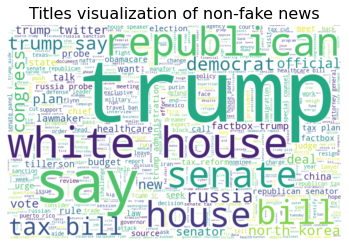

In [ ]:
wordcloud = WordCloud(max_words=1000,width=840, height=540, background_color="white").generate(' '.join(df_true_clean['title'].tolist()))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Titles visualization of non-fake news', fontsize = 16)
plt.show()


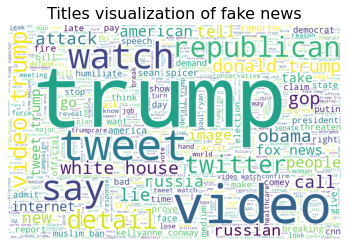

In [ ]:
wordcloud = WordCloud(max_words=1000,width=840, height=540, background_color="white").generate(' '.join(df_fake_clean['title'].tolist()))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Titles visualization of fake news', fontsize = 16)
plt.show()


## Average number of characters
The function below gets as arguments a dataframe and a name of a column and returns the average number of characters for that column.

In [ ]:
def average_chars_column(df, column):
  count = []
  for i, row in df.iterrows():
    count.append(len(row[column]))

  return sum(count)/len(count)


Graph that shows the average number of characters in title column for fake and non-fake news.

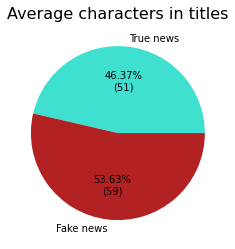

<Figure size 864x864 with 0 Axes>

In [ ]:
av_true = average_chars_column(df_true_clean, 'title')
av_fake = average_chars_column(df_fake_clean, 'title')

plt.pie(x = [av_true, av_fake], 
        labels = ['True news', 'Fake news'],
        colors = ['turquoise', 'firebrick'], 
        autopct = lambda p : '{:.2f}%\n({:.0f})'.format(p, (p/100)*(av_true+av_fake)))
plt.title('Average characters in titles', fontsize = 16)
plt.show()

Graph that shows the average number of characters in text column for fake and non-fake news.

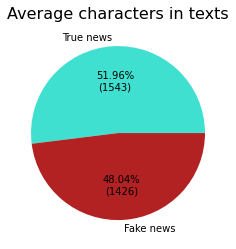

In [ ]:
av_true = average_chars_column(df_true_clean, 'text')
av_fake = average_chars_column(df_fake_clean, 'text')

plt.pie(x=[av_true, av_fake], 
        labels=['True news', 'Fake news'], 
        colors=['turquoise', 'firebrick'], 
        autopct = lambda p : '{:.2f}%\n({:.0f})'.format(p, (p/100)*(av_true+av_fake)))
plt.title('Average characters in texts', fontsize = 16)
plt.show()

## Distribution of the number of words
We will check the distribution of length of the titles and texts, in terms of words, in both true and fake data and in both dirty and clean datasets.

### Dirty datasets
The distribution of number of words for the initial (dirty) datasets.

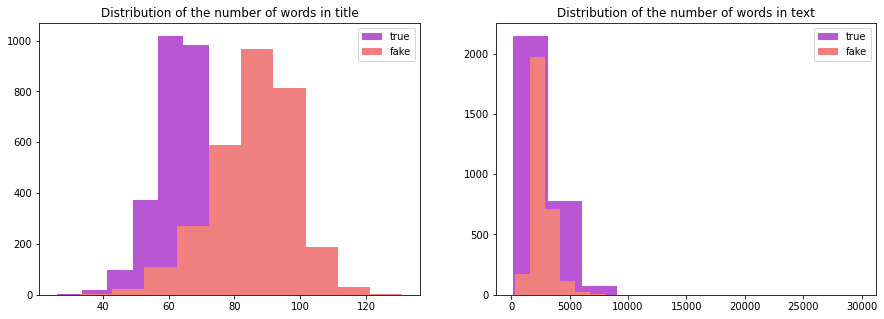

In [ ]:
data=[]
data.append(df_true.title.str.len())
data.append(df_fake.title.str.len())
data.append(df_true.text.str.len())
data.append(df_fake.text.str.len())

titles = ['Distribution of the number of words in title','Distribution of the number of words in text'] 

fig,a = plt.subplots(1,2)
fig.set_size_inches(15, 5)
a = a.ravel()

idx_data = 0
idx_titles = 0

for ax in a:

    ax.hist(data[idx_data], label='true', color='mediumorchid')
    ax.hist(data[idx_data + 1], label='fake', color='lightcoral')
    ax.set_title(titles[idx_titles])
    ax.legend()

    idx_data = idx_data + 2
    idx_titles = idx_titles + 1

plt.show()

### Clean datasets
The distribution of number of words for the clean datasets removed from stopwords.

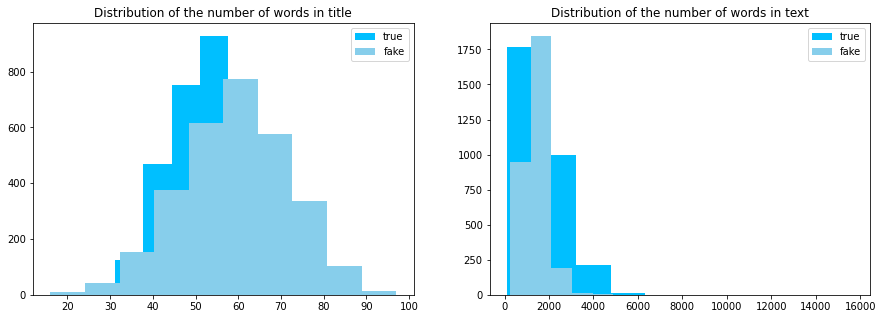

In [ ]:
data=[]
data.append(df_true_clean.title.str.len())
data.append(df_fake_clean.title.str.len())
data.append(df_true_clean.text.str.len())
data.append(df_fake_clean.text.str.len())

titles = ['Distribution of the number of words in title','Distribution of the number of words in text'] 

fig,a = plt.subplots(1,2)
fig.set_size_inches(15, 5)
a = a.ravel()

idx_data = 0
idx_titles = 0

for ax in a:

    ax.hist(data[idx_data], label='true', color='deepskyblue')
    ax.hist(data[idx_data + 1], label='fake', color='skyblue')
    ax.set_title(titles[idx_titles])
    ax.legend()

    idx_data = idx_data + 2
    idx_titles = idx_titles + 1

plt.show()

## The most common bigrams
The function below returns the most k common bigrams given a dataframe's column.

In [ ]:
def get_topk_bigrams(column, k = 20):
  "  returns bigram_names, bigram_counts "

  # Find bigrams through CountVectorizer
  bow_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', binary=True, max_features=k)
  bow_representation = bow_vectorizer.fit_transform(column)
  print(bow_vectorizer.get_feature_names())

  # To find the most common bigrams find the sum of each column
  bigram_counts = bow_representation.toarray().sum(axis=0)
  print(bigram_counts)

  df_sorted = pd.DataFrame(zip(bigram_counts, bow_vectorizer.get_feature_names()), 
                           columns=['bigram_counts', 'bigram_names'])
  df_sorted.sort_values(by='bigram_counts', inplace=True)

  return df_sorted['bigram_names'], df_sorted['bigram_counts']


Most common bigrams in titles.

['attorney general', 'factbox trump', 'house panel', 'house speaker', 'north korea', 'puerto rico', 'republican senator', 'republican tax', 'russia probe', 'say trump', 'special counsel', 'tax cut', 'tax plan', 'tax reform', 'travel ban', 'trump administration', 'trump jr', 'trump say', 'trump twitter', 'white house']
[ 28  72  27  31  96  34  57  35  50  31  27  42  44  46  36  54  36 110
  76 188]


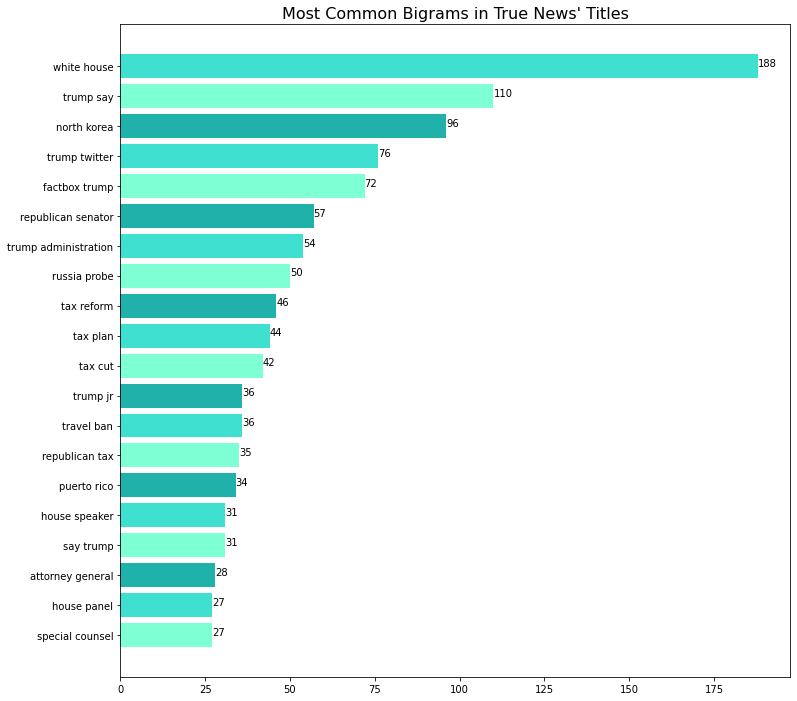

In [ ]:
names, counts = get_topk_bigrams(df_true_clean['title'])

plt.figure(figsize=(12,12))
plt.barh(y=names, width=counts, color = ['aquamarine', 'turquoise', 'lightseagreen'])

for index, value in enumerate(counts):
    plt.text(value, index, str(value))

plt.title("Most Common Bigrams in True News' Titles", fontsize = 16)
plt.show()

['donald trump', 'fake news', 'fox news', 'gop rep', 'ivanka trump', 'john mccain', 'kellyanne conway', 'muslim ban', 'new york', 'paul ryan', 'say trump', 'sean spicer', 'trump administration', 'trump jr', 'trump supporter', 'trump try', 'trump tweet', 'watch trump', 'white house', 'white supremacist']
[109  26  65  23  29  24  56  48  23  33  29  60  24  30  24  27  26  39
 105  30]


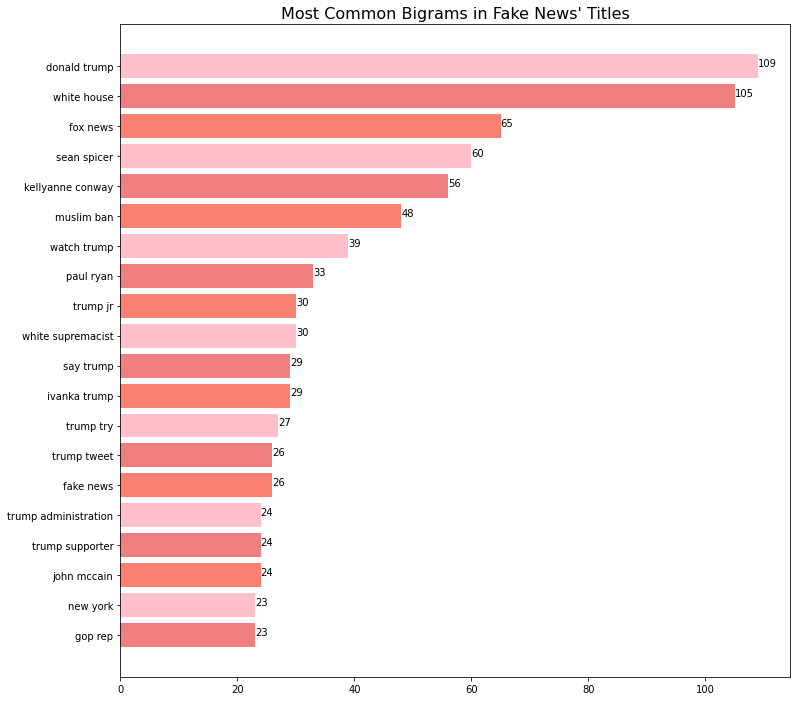

In [ ]:
names, counts = get_topk_bigrams(df_fake_clean['title'])

plt.figure(figsize=(12,12))
plt.barh(y=names, width=counts, color = ['lightcoral', 'pink', 'salmon'])

for index, value in enumerate(counts):
    plt.text(value, index, str(value))
    
plt.title("Most Common Bigrams in Fake News' Titles", fontsize = 16)
plt.show()

Most common bigrams in texts.

['barack obama', 'donald trump', 'house representatives', 'national security', 'new york', 'north korea', 'official say', 'president barack', 'president donald', 'republican senator', 'reuters president', 'say statement', 'say trump', 'tell reporter', 'trump administration', 'trump campaign', 'trump say', 'united states', 'washington reuters', 'white house']
[ 468 2172  685  276  501  277  331  403 2047  392  608  560  342  526
  551  308  507  913 1871 1066]


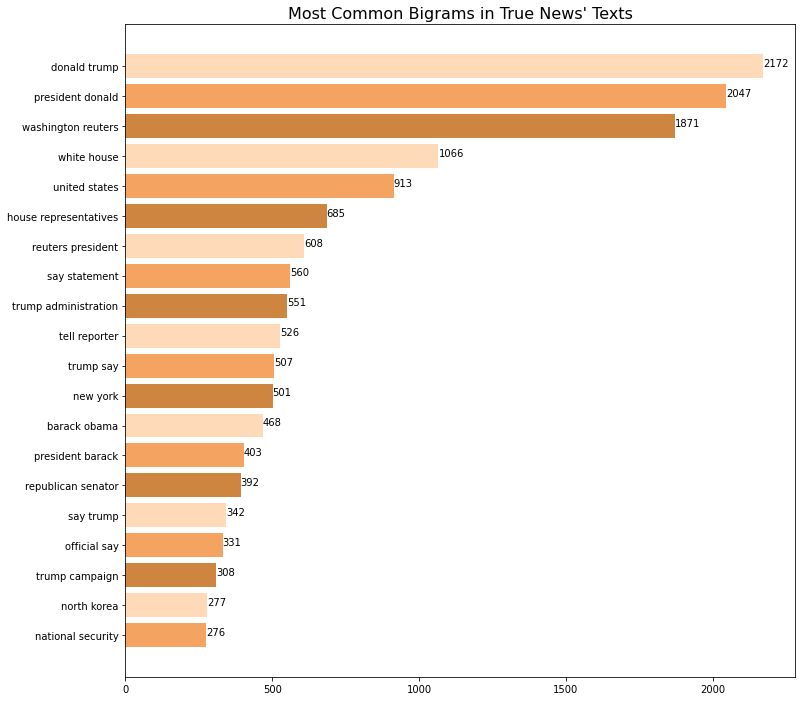

In [ ]:
names, counts = get_topk_bigrams(df_true_clean['text'])

plt.figure(figsize=(12,12))
plt.barh(y=names, width=counts, color = ['sandybrown', 'peachpuff', 'peru'])

for index, value in enumerate(counts):
    plt.text(value, index, str(value))
    
plt.title("Most Common Bigrams in True News' Texts", fontsize = 16)
plt.show()

['american people', 'chip somodevilla', 'donald trump', 'fake news', 'feature image', 'fox news', 'getty image', 'hillary clinton', 'look like', 'new york', 'pool getty', 'president obama', 'president trump', 'screen capture', 'somodevilla getty', 'trump administration', 'trump campaign', 'trump say', 'united states', 'white house']
[ 275  270 2110  267  459  262 2018  294  250  354  262  366  308  285
  256  404  232  352  600 1034]


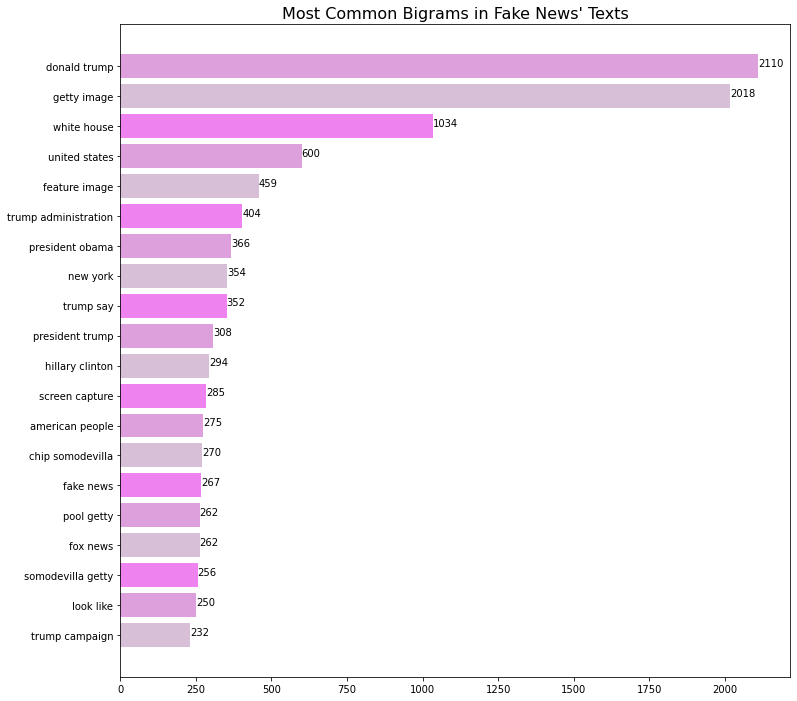

In [ ]:
names, counts = get_topk_bigrams(df_fake_clean['text'])

plt.figure(figsize=(12,12))
plt.barh(y=names, width=counts, color = ['thistle', 'plum', 'violet'])
for index, value in enumerate(counts):
    plt.text(value, index, str(value))
    
plt.title("Most Common Bigrams in Fake News' Texts", fontsize = 16)
plt.show()

# Split into Train and Test Set


In [44]:
# Insert label with value '1' at dataframe of non-fake news
dftrue = df_true_clean.copy()
dftrue.insert(4, 'label', 1)

# Insert label with value '0' at dataframe of fake news
dffake = df_fake_clean.copy()
dffake.insert(4, 'label', 0)

# Combine dftrue and dffake
df_combi = pd.concat([dftrue, dffake], ignore_index=True, sort=False)

# Insert a column that merges title, text and subject
df_combi['merged'] = df_combi[df_combi.columns[0:3]].apply(
    lambda x: ' '.join(x.dropna().astype(str)),
    axis=1
)

# Split dataframe to train and test sets
dftrain, dftest, trainlabel, testlabel = train_test_split(df_combi.drop(columns = ['label']), 
                                                          df_combi['label'], 
                                                          random_state=42, 
                                                          test_size=0.3)
# Keep the train and test labels as numpy arrays
trainlabel = np.asarray(trainlabel)
testlabel = np.asarray(testlabel)

# Create the train and test csv files
Location = r'/content/gdrive/MyDrive/ΤΕΔ/News_dataset/train.csv'
dftrain.to_csv(Location, index=False)

Location = r'/content/gdrive/MyDrive/ΤΕΔ/News_dataset/test.csv'
dftest.to_csv(Location, index=False)

In [45]:
dftrain.info()
dftest.info()
display(dftrain.head(1))
dftrain.iloc[0]['merged']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4200 entries, 4775 to 860
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    4200 non-null   object
 1   text     4200 non-null   object
 2   subject  4200 non-null   object
 3   date     4200 non-null   object
 4   merged   4200 non-null   object
dtypes: object(5)
memory usage: 196.9+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1800 entries, 1782 to 175
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    1800 non-null   object
 1   text     1800 non-null   object
 2   subject  1800 non-null   object
 3   date     1800 non-null   object
 4   merged   1800 non-null   object
dtypes: object(5)
memory usage: 84.4+ KB


title  ...                                             merged
4775  sarah palin gleefulli count bodi moab strike g...  ...  sarah palin gleefulli count bodi moab strike g...

[1 rows x 5 columns]

'sarah palin gleefulli count bodi moab strike get rip apart twitter tweet leav sarah palin resid manchurian couch potato drop mother bomb isi moab cost million complet care countless underprivileg famili trump strip social program healthcar cost whop million develop call trump presidenti learn stupid peopl like big explos realiti drop pound american peopl tax dollar hole blew satisfi ego distract problem like russia saturday sarah palin gleefulli celebr news afghan author increas number enemi combat kill whop dead bodi number death toll moab skyrocket news better https sarah palin sarahpalinusa april palin decis happi danc trump big boom extravaganza easter weekend taken light peopl believ rabbit guy hide egg russboot sarahpalinusa need chang panti lisa april russboot sarahpalinusa diaper rayn wild raynewild april sarahpalinusa oh sarah jesusi celebr drunken famili brawl digitalmindpatrol digitlmndpatrol april sarahpalinusa thought stood isi glorifi death necessari celebr hypocrit rand

# Feature Extraction
To analyse a preprocessed data, it needs to be converted into features. We have to represent words in a numeric format that is understandable by the computers.

## Bag-of-Words
The bag of words approach is one of the simplest word embedding approaches. We will convert a collection of text documents to a matrix of token counts with CountVectorizer. We set 'min_df = 2' to build the vocabulary ignoring terms that have a document frequency strictly lower than the given threshold. This value is a cut-off.

In [46]:
bow_vectorizer = CountVectorizer(ngram_range=(1, 2), max_df=1.0, min_df=2, stop_words='english')

bow_train = bow_vectorizer.fit_transform(dftrain.merged)
print(bow_vectorizer.get_feature_names())
# print(bow_train.toarray())
print(bow_train.shape)
print(type(bow_train))

bow_vectorizer.fit(dftrain.merged)
bow_test = bow_vectorizer.transform(dftest.merged)

print(bow_vectorizer.get_feature_names())
# print(bow_test.toarray())
print(bow_test.shape)

['aaa', 'aaron', 'aaron bernstein', 'aaron gouveia', 'aaron imag', 'aaron rupar', 'aarp', 'aarp advocaci', 'aarp repres', 'ab', 'aba', 'abadi', 'abadi offic', 'abadi said', 'abandon', 'abandon agreement', 'abandon american', 'abandon constitut', 'abandon effort', 'abandon end', 'abandon favor', 'abandon idea', 'abandon network', 'abandon nuclear', 'abandon pari', 'abandon plan', 'abandon quest', 'abandon respons', 'abandon sink', 'abandon texa', 'abandon trump', 'abb', 'abb lowel', 'abba', 'abba palestinian', 'abbi', 'abbi livingston', 'abbott', 'abbott laboratori', 'abbott said', 'abc', 'abc cbs', 'abc good', 'abc host', 'abc nbc', 'abc news', 'abc program', 'abc report', 'abc week', 'abcpolit', 'abcpolit septemb', 'abdel', 'abdel fattah', 'abdic', 'abdomen', 'abdomen polic', 'abdullah', 'abdullah ii', 'abdulrahman', 'abe', 'abe met', 'abe said', 'abedin', 'abedin aid', 'abel', 'abet', 'abfalecbaldwin', 'abfalecbaldwin januari', 'abfound', 'abfound abfalecbaldwin', 'abhor', 'abhorr', 

## TF-IDF
The TF-IDF scheme is a type of bag words approach where instead of adding zeros and ones in the embedding vector, you add floating numbers that contain more useful information compared to zeros and ones. We will convert a collection of raw documents to a matrix of TF-IDF features with TfidfVectorizer. We set 'min_df = 2' to build the vocabulary ignoring terms that have a document frequency strictly lower than the given threshold. This value is a cut-off.

In [47]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=1.0, min_df=2, stop_words='english')

tfidf_train = tfidf_vectorizer.fit_transform(dftrain.merged)

print(tfidf_vectorizer.get_feature_names())
# print(tfidf_train.toarray())
print(tfidf_train.shape)
print(type(tfidf_train))

tfidf_vectorizer.fit(dftrain.merged)
tfidf_test = tfidf_vectorizer.transform(dftest.merged)

print(tfidf_vectorizer.get_feature_names())
# print(tfidf_test.toarray())
print(tfidf_test.shape)

['aaa', 'aaron', 'aaron bernstein', 'aaron gouveia', 'aaron imag', 'aaron rupar', 'aarp', 'aarp advocaci', 'aarp repres', 'ab', 'aba', 'abadi', 'abadi offic', 'abadi said', 'abandon', 'abandon agreement', 'abandon american', 'abandon constitut', 'abandon effort', 'abandon end', 'abandon favor', 'abandon idea', 'abandon network', 'abandon nuclear', 'abandon pari', 'abandon plan', 'abandon quest', 'abandon respons', 'abandon sink', 'abandon texa', 'abandon trump', 'abb', 'abb lowel', 'abba', 'abba palestinian', 'abbi', 'abbi livingston', 'abbott', 'abbott laboratori', 'abbott said', 'abc', 'abc cbs', 'abc good', 'abc host', 'abc nbc', 'abc news', 'abc program', 'abc report', 'abc week', 'abcpolit', 'abcpolit septemb', 'abdel', 'abdel fattah', 'abdic', 'abdomen', 'abdomen polic', 'abdullah', 'abdullah ii', 'abdulrahman', 'abe', 'abe met', 'abe said', 'abedin', 'abedin aid', 'abel', 'abet', 'abfalecbaldwin', 'abfalecbaldwin januari', 'abfound', 'abfound abfalecbaldwin', 'abhor', 'abhorr', 

## Word2Vec
The advantages of using word embeddings over BoW/TF-IDF are:


*   Dimensionality reduction - significant reduction in the no. of features required to build a model.
*   It captures meanings of the words, semantic relationships and the different types of contexts they are used in.

We will work with gensim to generate new embeddings.

In [48]:
train_tokens = dftrain.merged.str.split(' ') # tokenization of dftrain data
test_tokens = dftest.merged.str.split(' ') # tokenization of dftest data

w2v_train_model = Word2Vec(train_tokens,
                    vector_size=400, # desired no. of features/independent variables
                    seed=32,
                    negative=5,
                    sg=0,
                    min_count=1,
                    window=1)

w2v_train_model.build_vocab(train_tokens)  # prepare the model vocabulary of train set

w2v_train_model.train(train_tokens, total_examples=w2v_train_model.corpus_count, epochs=5); # train the model

print(w2v_train_model.wv.index_to_key)

['trump', 'said', 'presid', 'republican', 'hous', 'state', 'senat', 'donald', 'peopl', 'white', 'tax', 'imag', 'democrat', 'like', 'report', 'time', 'year', 'new', 'reuter', 'american', 'administr', 'russia', 'washington', 'unit', 'elect', 'say', 'campaign', 'nation', 'offici', 'countri', 'work', 'obama', 'govern', 'want', 'News', 'investig', 'politicsNews', 'news', 'told', 'vote', 'russian', 'support', 'includ', 'plan', 'congress', 'call', 'think', 'offic', 'realdonaldtrump', 'know', 'law', 'right', 'go', 'day', 'week', 'tweet', 'meet', 'committe', 'feder', 'need', 'percent', 'ask', 'twitter', 'secur', 'statement', 'way', 'leader', 'come', 'court', 'legisl', 'issu', 'help', 'thing', 'tri', 'repres', 'attack', 'month', 'look', 'depart', 'million', 'group', 'media', 'public', 'polici', 'polit', 'deal', 'accord', 'order', 'north', 'major', 'busi', 'compani', 'america', 'act', 'fact', 'job', 'parti', 'cut', 'talk', 'general', 'member', 'rule', 'tuesday', 'foreign', 'continu', 'program', '

We are going to use the word vectors from word2vec model to create a vector representation for an entire tweet (sentence) by taking the mean of all the word vectors present in the tweet. The function below saves a vector for each tweet by taking the mean of the vectors of the words present in the tweet.

In [49]:
# The Word2Vec model converts words to their corresponding vectors. 
# Let's see how we can view vector representation of any particular word.

# v1 = w2v_train.wv['democrat']
# print(len(w2v_train.wv['democrat'])) # prints the vector_size
# print(v1)

def w2v_representation(all_words, w2vmodel, vector_size = 200):

  # Initialize numpy array to have vector_size for each sentece in 'all_words' list
  w2v_representation = np.zeros(shape = (len(all_words), vector_size))

  for i, tokens in enumerate(all_words):
    vector = np.zeros(vector_size).reshape((1, vector_size))
    count = 0
    for j, word in enumerate(tokens):
        try:
          vector += w2vmodel.wv[word].reshape((1, vector_size))
          count += 1
        except KeyError: # handling the case where the token is not in vocabulary
          continue
    # Get the mean of vector
    if count != 0:
      vector /= count
    w2v_representation[i,:] = vector

  return w2v_representation

Create w2v representation for both train and test set.

In [50]:
w2v_train = w2v_representation(train_tokens, w2v_train_model, 400)
print(w2v_train)
print(type(w2v_train))

w2v_test = w2v_representation(test_tokens, w2v_train_model, 400)
print(w2v_test)

[[ 0.01508327  0.08765391  0.10903229 ...  0.03518823  0.09163636
  -0.61053144]
 [ 0.00641485  0.09356443  0.24477852 ...  0.02811493  0.15598393
  -0.57091686]
 [-0.04566149  0.11367395  0.13717479 ... -0.05113566  0.13549368
  -0.54196211]
 ...
 [ 0.01256273  0.04492846  0.18062801 ... -0.05284917  0.13440505
  -0.54395666]
 [-0.00204261 -0.02032085  0.08620603 ...  0.07265254  0.08957418
  -0.49534832]
 [-0.02832509  0.09027628  0.18103039 ...  0.08982599  0.12392387
  -0.45627715]]
<class 'numpy.ndarray'>
[[-0.05526303  0.16336051  0.18012494 ...  0.02495521  0.15054736
  -0.44144632]
 [ 0.02455496  0.07569467  0.1222828  ...  0.04060629  0.11659615
  -0.59564898]
 [-0.05960964  0.09977042  0.1863756  ... -0.04686055  0.07556833
  -0.49178178]
 ...
 [-0.19033494  0.17255008  0.29251071 ... -0.1293009   0.09669755
  -0.53974868]
 [-0.11461396  0.19707355  0.30183101 ... -0.10798721  0.12779796
  -0.56610506]
 [-0.11188628  0.1174858   0.17305217 ...  0.01034029  0.06966597
  -0.438

In [ ]:
import gensim.downloader as api

# download the pretrained embeddings
glove_vectors = api.load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded


# Feature-processing
Feature normalization is used in machine learning to make model training less sensitive to the scale of features.
The function below returns word representations normalized.

In [51]:
def Standard_Scaler(traindata, testdata):
  " takes 2 dense arrays one for train data and one for test data and returns standarized train and test data "
  scaler = StandardScaler().fit(traindata)
  traindata = scaler.transform(traindata)
  testdata = scaler.transform(testdata)
  return traindata, testdata


def MaxAbs_Scaler(traindata, testdata):
  transformer = MaxAbsScaler().fit(traindata)
  scaledtrain = transformer.transform(traindata)
  scaledtest = transformer.transform(testdata)
  return scaledtrain, scaledtest

In [52]:
bow_train, bow_test = MaxAbs_Scaler(bow_train, bow_test)
print(bow_train.mean(axis=0))

tfidf_train, tfidf_test = MaxAbs_Scaler(tfidf_train, tfidf_test)
print(tfidf_train.mean(axis=0))

w2v_train, w2v_test = Standard_Scaler(w2v_train, w2v_test)
print(w2v_train)

[[0.00035714 0.00309524 0.00071429 ... 0.00042857 0.00047619 0.00047619]]
[[0.0003347  0.00264789 0.00068259 ... 0.00055569 0.00043356 0.00044222]]
[[ 0.98761214  0.08935159 -0.8249532  ...  0.4825572  -0.57692039
  -1.93787209]
 [ 0.76169547  0.20956934  1.50845901 ...  0.34386871  1.03963557
  -1.32728829]
 [-0.59552095  0.61858979 -0.34119729 ... -1.21002493  0.52487444
  -0.88100556]
 ...
 [ 0.92192181 -0.77966872  0.40574267 ... -1.2436222   0.49752544
  -0.91174787]
 [ 0.54127656 -2.10681614 -1.21732569 ...  1.21713296 -0.62872695
  -0.16254212]
 [-0.14369859  0.14268969  0.4126593  ...  1.55385856  0.23421462
   0.43966597]]


# Classifiers and Evaluation Metrics
We are going to evaluate and record the performance of each method in test data using the following evaluation metrics:

* **Accuracy score**: It is the fraction of predictions our model got right.

* **F1 score**: It is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. It is suitable for uneven class distribution problems.

## Logistic Regression
Logistic Regression is a classification algorithm.  The training algorithm uses the one-vs-rest (OvR) scheme if the ‘multi_class’ option is set to ‘ovr’, and uses the cross-entropy loss if the ‘multi_class’ option is set to ‘multinomial’. 

### Bag-of-Words Feautures
We will first try to fit the logistic regression model on the Bag-of-Words features.

In [53]:
lreg_model = LogisticRegression()
lreg_model.fit(bow_train, trainlabel) # training the model

accuracy = lreg_model.score(bow_test, testlabel)
print("accuracy = ", accuracy * 100, "%")

accuracyScore = accuracy_score(testlabel, lreg_model.predict(bow_test))
print("Accuracy score = ", accuracyScore * 100, "%")

f1 = f1_score(testlabel, lreg_model.predict(bow_test), average='macro')
print("F1 score = ", f1 * 100, "%")

accuracy =  100.0 %
Accuracy score =  100.0 %
F1 score =  100.0 %


### TF-IDF Features

In [54]:
lreg_model = LogisticRegression()
lreg_model.fit(tfidf_train, trainlabel) # training the model

accuracy = lreg_model.score(tfidf_test, testlabel)
print("accuracy = ", accuracy * 100, "%")

accuracyScore = accuracy_score(testlabel, lreg_model.predict(tfidf_test))
print("Accuracy score = ", accuracyScore * 100, "%")

f1 = f1_score(testlabel, lreg_model.predict(tfidf_test), average='macro')
print("F1 score = ", f1 * 100, "%")

accuracy =  99.83333333333333 %
Accuracy score =  99.83333333333333 %
F1 score =  99.83324681725301 %


### Word2Vec Features

In [55]:
lreg_model = LogisticRegression(max_iter=1000)
lreg_model.fit(w2v_train, trainlabel) # training the model

accuracy = lreg_model.score(w2v_test, testlabel)
print("accuracy = ", accuracy * 100, "%")

accuracyScore = accuracy_score(testlabel, lreg_model.predict(w2v_test),)
print("Accuracy score = ", accuracyScore * 100, "%")

f1 = f1_score(testlabel, lreg_model.predict(w2v_test), average='macro')
print("F1 score = ", f1 * 100, "%")

accuracy =  99.22222222222223 %
Accuracy score =  99.22222222222223 %
F1 score =  99.22171393416194 %


## Naive Bayes
Naive Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong (naïve) independence assumptions between the features .



### Bag-of-Words Features

In [56]:
nb_model = MultinomialNB()

nb_model.fit(bow_train, trainlabel) # training the model

accuracy = nb_model.score(bow_test, testlabel)
print("accuracy = ", accuracy * 100, "%")

prediction = nb_model.predict(bow_test)
accuracyScore = accuracy_score(testlabel, prediction)
print("Accuracy score = ", accuracyScore * 100, "%")

f1 = f1_score(testlabel, prediction, average='macro')
print("F1 score = ", f1 * 100, "%")

accuracy =  98.77777777777777 %
Accuracy score =  98.77777777777777 %
F1 score =  98.77717391304348 %


### TF-IDF Features

In [57]:
nb_model.fit(tfidf_train, trainlabel) # training the model

accuracy = nb_model.score(tfidf_test, testlabel)
print("accuracy = ", accuracy * 100, "%")

prediction = nb_model.predict(tfidf_test)
accuracyScore = accuracy_score(testlabel, prediction)
print("Accuracy score = ", accuracyScore * 100, "%")

f1 = f1_score(testlabel, prediction, average='macro')
print("F1 score = ", f1 * 100, "%")

accuracy =  98.22222222222223 %
Accuracy score =  98.22222222222223 %
F1 score =  98.22151082655284 %


### Word2Vec Features

In [58]:
nb_model = GaussianNB()
nb_model.fit(w2v_train, trainlabel) # training the model

accuracy = nb_model.score(w2v_test, testlabel)
print("accuracy = ", accuracy * 100, "%")

prediction = nb_model.predict(w2v_test)
accuracyScore = accuracy_score(testlabel, prediction)
print("Accuracy score = ", accuracyScore * 100, "%")

f1 = f1_score(testlabel, prediction, average='macro')
print("F1 score = ", f1 * 100, "%")

accuracy =  89.38888888888889 %
Accuracy score =  89.38888888888889 %
F1 score =  89.38338069844262 %


## Support Vector Machines
Support-vector machines are supervised learning models with associated learning algorithms that analyze data for classification and regression analysis. 

At first, we run GridSearchCV to find the best parameters for svm.SVC().

In [ ]:
parameters = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

### Bag-of-Words Features

In [ ]:
svc = svm.SVC()
clf_search = GridSearchCV(svc, parameters)
clf_search.fit(bow_train, trainlabel)
clf_search.best_params_

{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}

Apply those parameters

In [59]:
clf = svm.SVC(C= 10, gamma= 0.001, kernel='rbf')
clf.fit(bow_train, trainlabel)

accuracy = clf.score(bow_test, testlabel)
print("accuracy = ", accuracy * 100, "%")

prediction = clf.predict(bow_test)
accuracyScore = accuracy_score(testlabel, prediction)
print("Accuracy score = ", accuracyScore * 100, "%")

f1 = f1_score(testlabel, prediction, average='macro')
print("F1 score = ", f1 * 100, "%")

accuracy =  100.0 %
Accuracy score =  100.0 %
F1 score =  100.0 %


### TF-IDF Features

In [ ]:
svc = svm.SVC()
clf_search = GridSearchCV(svc, parameters)
clf_search.fit(tfidf_train, trainlabel)
clf_search.best_params_

{'C': 10, 'kernel': 'linear'}

Apply those parameters

In [60]:
clf = svm.SVC(C= 10, kernel='linear')
clf.fit(tfidf_train, trainlabel)

accuracy = clf.score(tfidf_test, testlabel)
print("accuracy = ", accuracy * 100, "%")

prediction = clf.predict(tfidf_test)
accuracyScore = accuracy_score(testlabel, prediction)
print("Accuracy score = ", accuracyScore * 100, "%")

f1 = f1_score(testlabel, prediction, average='macro')
print("F1 score = ", f1 * 100, "%")

accuracy =  99.94444444444444 %
Accuracy score =  99.94444444444444 %
F1 score =  99.94441272195151 %


### Word2Vec Features

In [ ]:
svc = svm.SVC()
clf_search = GridSearchCV(svc, parameters)
clf_search.fit(w2v_train, trainlabel)
clf_search.best_params_

{'C': 10, 'kernel': 'linear'}

Apply those parameters

In [61]:
clf = svm.SVC(C= 10, kernel='linear')
clf.fit(w2v_train, trainlabel)

accuracy = clf.score(w2v_test, testlabel)
print("accuracy = ", accuracy * 100, "%")

prediction = clf.predict(w2v_test)
accuracyScore = accuracy_score(testlabel, prediction)
print("Accuracy score = ", accuracyScore * 100, "%")

f1 = f1_score(testlabel, prediction, average='macro')
print("F1 score = ", f1 * 100, "%")

accuracy =  99.0 %
Accuracy score =  99.0 %
F1 score =  98.99934648677964 %


## Random Forests
Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean/average prediction (regression) of the individual trees.

### Bag-of-Words Features
We will train our RandomForest model on the Bag-of-Words features and check its performance on test set.

In [62]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(bow_train, trainlabel) 
prediction = rf.predict(bow_test)

accuracy = accuracy_score(testlabel, prediction)
print("accuracy = ", accuracy * 100, "%")

f1 = f1_score(testlabel, prediction)
print("F1 score = ", f1 * 100, "%")

accuracy =  99.83333333333333 %
F1 score =  99.836867862969 %


### TF-IDF Features

In [63]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(tfidf_train, trainlabel) 
prediction = rf.predict(tfidf_test)

accuracy = accuracy_score(testlabel, prediction)
print("accuracy = ", accuracy * 100, "%")

f1 = f1_score(testlabel, prediction)
print("F1 score = ", f1 * 100, "%")

accuracy =  99.8888888888889 %
F1 score =  99.89130434782608 %


### Word2Vec Features

In [64]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(w2v_train, trainlabel) 
prediction = rf.predict(w2v_test)

accuracy = accuracy_score(testlabel, prediction)
print("accuracy = ", accuracy * 100, "%")

f1 = f1_score(testlabel, prediction)
print("F1 score = ", f1 * 100, "%")

accuracy =  96.05555555555556 %
F1 score =  96.14340032590985 %


# Beat the Benchmark